### 0. Notebook setting

In [15]:
%matplotlib inline

### 1. Introduction

This notebook shows how to use the ```mp_tiling``` implementation, available under https://github.com/soply/mpgraph, that serves to get insights into the support tiling of a solution to the multi-penalty problem
$$ J_{\beta,\alpha}(u,v) : = \| A(u+v)-y \|_{\ell_2}^2 +  \alpha \| u\|_{\ell_1} + \beta  \| v\|_{\ell_2}^{2}, $$
where $A \in \mathbb{R}^{m \times n}$ is a sampling matrix, $u \in \mathbb{R}^{n}$ is a (usually sparse) vector,
$v \in \mathbb{R}^{m}$ is usually a noise component and $y = A(u+v) \in \mathbb{R}^{m}$ are measurements of signal + noise under the sampling matrix. In this notebook, we will only explain how to use the code but not what it does or what the actual purpose of the multi-penalty regularisation is. For this purpose, consult the paper 'Extension of the Lasso-path algorithm to multi-parameter regularization' by Markus Grasmair et al.

### 2. Importing the toolbox and setting up a problem
In this section we simply load the necessary code. Depending on where the source code is located, the ```relative_path_to_src``` may be needs to be adapted.

In [16]:
import sys
relative_path_to_src = '..' # My relative path to the source code
sys.path.append(relative_path_to_src)
from tiling import Tiling

Now we have imported the ```Tiling``` class that serves as the main interface to use the ```mp_tiling``` toolbox. Next we have to set up a problem, eg. by using methods for the creation of a random problem given in the ```problem_factory``` subfolder of the repository. Note that the further details on the problem dictionary can be found in the documentation of the source code.

In [17]:
# Located at ../../../PhD/tiling_graph/mpgraph/problem_factory/
from problem_factory.synthetic_random_data import create_specific_problem_data_from_problem 
# Problem specifications (see source code doc for the detailed information).
problem = {
    'n_measurements': 250, # m
    'n_features': 1250, # n
    'sparsity_level': 6, # Sparsity level of u
    'smallest_signal': 1.5, # Smallest signal size in u
    'largest_signal': 2.0, # Largest signal size in u
    'noise_type_signal': 'linf_bounded', # The noise v can be of type 'linf_bounded', 'l2_bounded' or 'gaussian'
    'noise_lev_signal': 0.2, # Noise level of the vector v (exact meaning depends on noise type)
    'noise_type_measurements': 'gaussian', # Additional measurement noise if desired. Can be of the same type.
    'noise_lev_measurements': 0.0, # Noise level of the additional measurement noise. 
    'random_seed': 123 # Just to fix the randomness
}
# Create the data from the problem
A, y, u_gen, v_gen = create_specific_problem_data_from_problem(problem)

### 3. Creating the support tiling

Now that we have created the problem data, we can use it to instantiate an object of the ```Tiling``` class to calculate the support tiling. We can further specify a ```prior``` (on v) that will reformulate the problem into 
$$ J_{\beta,\alpha}(u,v) : = \| A(u+v)-(y-A*prior) \|_{\ell_2}^2 +  \alpha \| u\|_{\ell_1} + \beta  \| v-prior\|_{\ell_2}^{2}, $$ if we have additional information on the noise. We will not use this option. However, we can also specify some options for the tiling creation that overwrites the specified default options. We will do this for illustration, but again we refer to the code for more details:

In [18]:
tiling_options = {
    'verbose': 0, # Verbosity level defining what will be output. 
    'mode': 'LARS', # Method to find the child nodes of a particular tiling element. 'LASSO' and 'LARS' possible.
    'print_summary' : True, # Whether or not to print a summary of all tiles at the end.
    "env_minimiser": "scipy_brentq" # Minimiser used for the envelope minimiser (see referred paper).
}

Having specified these options, we will now create the ```tiling``` object:

In [19]:
tiling = Tiling(A, y, prior = None, options = tiling_options)

To finally create the support tiling, we will have to run the method ```create_tiling``` of the object ```tiling```. Moreover, this method requires it to specify certain parameters, namely ```beta_min``` and ```beta_max``` that define the corridor of $\beta$'s in which we want to solve the multi-penalty problem, as well as ```n_sparsity``` defining the maximum sparsity level up to which we want to construct the support tiling. We choose a corridor of $\beta \in [0.01,10.0]$ and search for all solutions that can be reached from within maximally $10$ Lasso-path steps (ie. have maximal sparsity of 10).

In [20]:
beta_min, beta_max = 0.01, 10.0
n_sparsity = 10
tiling.create_tiling(beta_min, beta_max, n_sparsity)

Beginning tiling creation...
Finished tiling creation...
  Identifier      alpha_min    beta_min    alpha_max    beta_max    #Supp    Sym. Dif.
------------  -------------  ----------  -----------  ----------  -------  -----------
          15  100              0.01      100           10               0            1
          13    0.00389908     0.01        0.287322     0.896843        1            2
           8    0.287322       0.896843    1.30949     10               1            2
           5    0.00381038     0.01        1.23498     10               2            3
           9    0.00326958     0.01        1.06261     10               3            4
           2    0.0030176      0.01        0.977768    10               4            5
          11    0.00264198     0.01        0.885667    10               5            6
           3    0.00252697     0.01        0.813447    10               6            7
          12    0.00088245     0.01        0.0424349    0.551036        7

Before we discuss the output of the table, let us quickly check whether or not the created tiling is correct (sort of a debug-check).

In [21]:
tiling.verify_tiling()

Verification passed


The result is that the verification passed, hence all child/parent relations and the respective $\beta$-ranges of stepping from one tile to another make sense. Thus we can now go to the output of the above table.

The table shows a summary of the tiling creation, listing all tiles that have been found as well as some key properties. These are the minimal $(\alpha, \beta)$ pair, the maximal $(\alpha, \beta)$ as well as the support size. Note that the symmetric difference does here not apply since we have not compared to the generating ```u_gen```. To have this information, we can again call the table creation and providing the generating ```u_gen``` as additional information.

In [22]:
tiling.show_table(u_gen)

  Identifier      alpha_min    beta_min    alpha_max    beta_max    #Supp    Sym. Dif.
------------  -------------  ----------  -----------  ----------  -------  -----------
          15  100              0.01      100           10               0            6
          13    0.00389908     0.01        0.287322     0.896843        1            5
           8    0.287322       0.896843    1.30949     10               1            5
           5    0.00381038     0.01        1.23498     10               2            4
           9    0.00326958     0.01        1.06261     10               3            3
           2    0.0030176      0.01        0.977768    10               4            2
          11    0.00264198     0.01        0.885667    10               5            1
           3    0.00252697     0.01        0.813447    10               6            0
          12    0.00088245     0.01        0.0424349    0.551036        7            1
          16    0.0424349      0.551036    

We see here that, in the tiling, the only support with 6 entries actually belongs to the real support. However without knowing the real solution, we can use certain support selection methods. Before we will discuss these in the last section, we want to show some additional visualisation tools.

### 4. Visualisation of the results

We have several options to visualise the results. For example, using the created tiling, we can reconstruct the complete tiling in the respective parameter subspace of $\mathbb{R}^2$. As a remark it should be noted that this exact recreation of the tiling is computationally very demanding as soon as the dimensions go up.

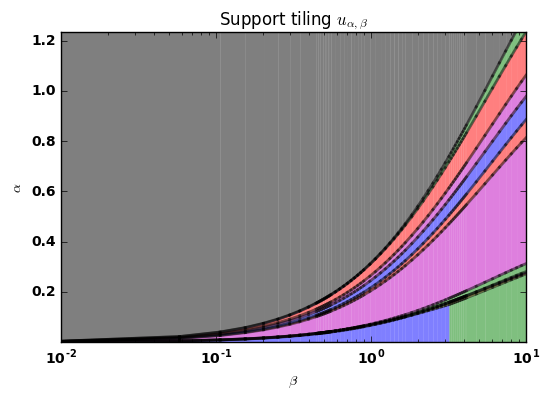

In [23]:
tiling.plot_tiling(n_disc=10) # Decreasing n_disc greatly reduces the computational effort! 

In this plot, the black fat lines represent a new layer, meaning that these supports are reached from the support above the black line by performing the Lasso-path algorithm for some beta inside the respective range; and all differently colored areas belong to different supports. We want to note here that due to the lack of the results to layer 11, the blue and green area's in the last layer (for $\alpha$ small) are continued until $\alpha =0$. If we would calculate more layers, this would be not the case, hence the green and dark blue area's in layer 11 do not constitute the parameter space that yields the respective support.

A second possibility to visualise the result is by using a graph view as shown below:

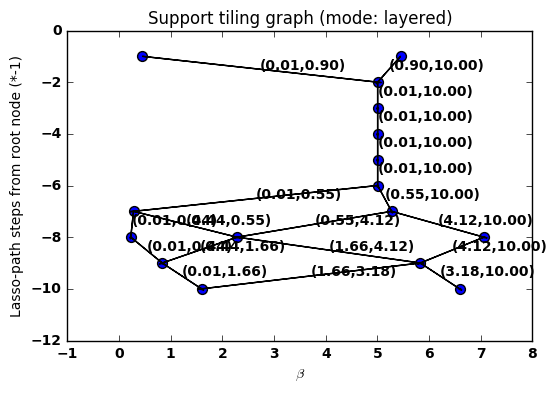

In [24]:
tiling.plot_tiling_graph(y_mode = 'layered')

Here we see several vertices, each corresponding to a single tile (the root tile is spared, therefore the graph is not rooted here) and the corresponding edges if we can reach a specific tile from another one. The ranges that are assigned to the edges are the values of $\beta$ from which a we can go from one vertex to another one.

Lastly, there is also the option to call the ```plot_tiling``` method with ```y_mode = 'normal'``` in which we construct again a graph with vertices and edges where the vertices are now located at the approximately the center of mass of their respective parameter areas in $\mathbb{R}^2$. Since these areas are usually not equally sized and not simply shaped, the center of mass however contains only limited information. Therefore, using ```plot_tiling``` or ```show_table``` should be preferred. For completeness however, we show the following result of the normal mode. 

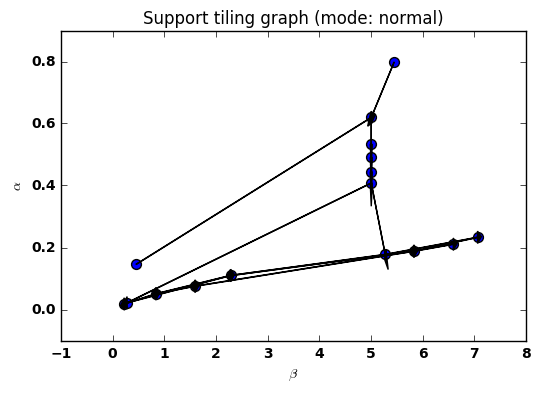

In [25]:
tiling.plot_tiling_graph(y_mode = 'normal')

### 5. Support selection 

### 6. Alternative: Using terminal commands and the script ```run_single.py```

As an alternative to the here provided way of testing a simple experiment, there are also terminal-runnable scripts available for different kinds of task. These additionally store the results in some specified subfolder of the head folder results_single. We refer to the documentation or the help call of the ```run_single.py``` script for more information on how to run these scripts. An important note however is that, when using these scripts, the problems are specified inside the file. This is because it may be tedious to do it via shell options or files. 

An exemplary shall call is depicted below (provided we are in the folder of run_single.py):

In [26]:
!python run_single.py -i test1 -v true -p graph_layered

python: can't open file 'run_single.py': [Errno 2] No such file or directory


In this, the first options is the identifier or the subfolder under which the results are stored, the -v option is either true or false and determines whether or not we want to verify the tilings validity, and the -p options is for plotting and can be 'graph_layered', 'graph' or 'tiling'.